<a href="https://colab.research.google.com/github/sthalles/SimCLR/blob/master/feature_eval/linear_feature_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install gdown

In [2]:
# folder_name = 'resnet-18_80-epochs'

folder_name = '../../runs/Feb12_14-36-05_frank-lab2/'

# !gdown https://drive.google.com/uc?id=1c4eVon0sUd-ChVhH6XMpF6nCngNJsAPk # ResNet 18 --> 40 epochs trained
# !gdown https://drive.google.com/uc?id=1L0yoeY9i2mzDcj69P4slTWb-cfr3PyoT # ResNet 18 --> 80 epochs trained
# !unzip resnet-18_80-epochs
# !ls

In [3]:
!ls

linear_feature_eval_cifar.ipynb			resnet-18_80-epochs.zip
linear_feature_eval_galaxy.ipynb		stl10_binary
linear_feature_eval.ipynb			stl10_binary.tar.gz
mini_batch_logistic_regression_evaluator.ipynb	stl10_binary.tar.gz.1
resnet-18_80-epochs


In [19]:
# download and extract cifar10 binary
!wget --no-check-certificate https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
!tar -zxvf cifar-10-binary.tar.gz
!ls

--2022-02-13 16:00:08--  https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: ‘cifar-10-binary.tar.gz.1’

cifar-10-binary.tar 100%[===================>] 162.17M   106MB/s    in 1.5s    

2022-02-13 16:00:10 (106 MB/s) - ‘cifar-10-binary.tar.gz.1’ saved [170052171/170052171]

cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin
cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin
cifar-10-batches-bin/data_batch_4.bin
cifar-10-batches-bin/test_batch.bin
cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin
cifar-10-batches-bin/data_batch_2.bin
cifar-10-batches-bin
cifar-10-binary.tar.gz
cifar-10-binary.tar.gz.1
linear_feature_eval_cifar.ipynb
linear_feat

In [5]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import importlib.util

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [7]:
checkpoints_folder = os.path.join(folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/home/joshua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 512,
 'epochs': 80,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'None',
 'log_every_n_steps': 50,
 'weight_decay': '10e-6',
 'fp16_precision': False,
 'model': {'out_dim': 256, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(96,96,3)',
  'num_workers': 0,
  'valid_size': 0.05},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [8]:
checkpoints_folder

'../../runs/Feb12_14-36-05_frank-lab2/checkpoints'

In [44]:
import torch
import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [45]:
# load STL-10 train data
for i, (X_test, y_test) in enumerate(testloader):
    print(X_test.shape)
    
    if i > 10:
        break

torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)


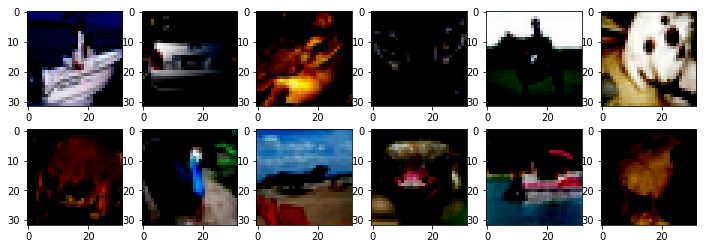

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    sample_image = np.asarray(X_test[i])
    print(sample_image.shape)
    sample_image = np.moveaxis(sample_image, 0, -1)
    ax.imshow(sample_image)
plt.show()

In [12]:
# load STL-10 test data
# X_test, y_test = _load_stl10("test")

test images
(8000, 3, 96, 96)
(8000,)


## Test protocol #1 PCA features

In [13]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train.reshape((X_train.shape[0],-1)))

pca = PCA(n_components=config['model']['out_dim'])

X_train_pca = pca.fit_transform(scaler.transform(X_train.reshape(X_train.shape[0], -1)))
X_test_pca = pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1)))

print("PCA features")
print(X_train_pca.shape)
print(X_test_pca.shape)

PCA features
(5000, 256)
(8000, 256)


In [14]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression(random_state=0, max_iter=1200, solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    
    print("-------------------------------")
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))

In [15]:
linear_model_eval(X_train_pca, y_train, X_test_pca, y_test)

## clean up resources
del X_train_pca
del X_test_pca

KeyboardInterrupt: 

## Protocol #2 Logisitc Regression

In [47]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, 'resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [48]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [49]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [50]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(5000, 512)


In [59]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

Test features
(1000, 512)


/home/joshua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/joshua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [56]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_test_feature)

linear_model_eval(scaler.transform(X_test_feature), y_test, scaler.transform(X_test_feature), y_test)

#del X_test_feature
#del X_test_feature

NameError: name 'X_test_feature' is not defined

In [ ]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

In [57]:
### plotting features and 

for i in range(10):
    
    if y_test[i] == 1 or y_test[i] == 5:
        plt.imshow(X_test[i].transpose(1,2,0))
        plt.title(y_test[i])
        plt.show()

        

        plt.plot(np.log(X_test_feature[i]), '.')
        plt.title("representation")
        plt.show()
        
    

# fig, axs = plt.subplots(nrows=2, ncols=6, constested_layout=False, figsize=(12,4))

# for i, ax in enumerate(axs.flat):
#   ax.imshow(X_test[i].transpose(1,2,0))
# plt.show()

TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (name dim0, name dim1)
 * (int dim0, int dim1)


In [60]:
import umap


embedding = umap.UMAP().fit_transform(X_test_feature)
"umapembed=pd.DataFrame({'labels':labels,'umap0':embedding[:,0],'umap1':embedding[:,1]})\n",
"# sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=labels,\n",
"#                 hue_order=['-0.94', '-0.5', '0', '0.5', '0.94'],\n",
"#                 linewidth=0,s=1,palette='viridis', legend='full')\n",
"sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=labels,\n",
"                linewidth=0,s=3,palette='viridis', legend='full')\n",
"plt.legend(bbox_to_anchor=(0.98, 1))\n",
"plt.show()"

/home/joshua/miniconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


'plt.show()'

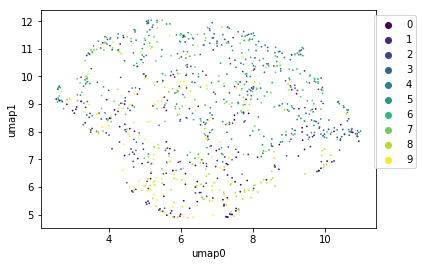

In [62]:
import pandas as pd
import seaborn as sns
umapembed=pd.DataFrame({'labels':y_test,'umap0':embedding[:,0],'umap1':embedding[:,1]})
# sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=labels, hue_order=['-0.94', '-0.5', '0', '0.5', '0.94'],
# linewidth=0,s=1,palette='viridis', legend='full')
sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=y_test, linewidth=0,s=3,palette='viridis', legend='full')
plt.legend(bbox_to_anchor=(0.98, 1))
plt.show()